In [19]:
import numpy as np
import scipy as sp
import scipy.sparse as sps
import scipy.io as spio
import scipy.sparse.linalg as spsla
import trips.phantoms as phantom
import astra
from resizeimage import resizeimage
import matplotlib.pyplot as plt
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pylops

In [20]:
views = 60
sizex = 128
sizey = 128

In [60]:
TT = Tomograph()
(x_true, nx, ny) = TT.gen_true(128, 128, 'ppower')
Amat = TT.forward_Op_mat(sizex = 128, sizey = 128, views = 60)

In [61]:
Aop = TT.for_op(sizex = 128, sizey = 128, views = 60)

In [171]:
class Tomograph():
    def __init__(self,**kwargs):
        seed = kwargs.pop('seed',2022)
    def define_proj_id(self, sizex, sizey, views, **kwargs):
        self.dataset = kwargs['dataset'] if ('dataset' in kwargs) else False
        self.nx = sizex
        self.ny = sizey
        self.p = int(np.sqrt(2)*self.nx)    # number of detector pixels
        self.q = views           # number of projection angles
        self.views = views
        self.theta = np.linspace(0, 2*np.pi, self.q, endpoint=False)   # in rad
        self.source_origin = 3*self.nx                     # source origin distance [cm]
        self.detector_origin = self.nx                      # origin detector distance [cm]
        self.detector_pixel_size = (self.source_origin + self.detector_origin)/self.source_origin
        self.detector_length = self.detector_pixel_size*self.p   # detector length
        self.vol_geom = astra.create_vol_geom(self.nx,self.nx)
        self.proj_geom = astra.create_proj_geom('fanflat', self.detector_pixel_size, self.p, self.theta, self.source_origin, self.detector_origin)
        self.proj_id = astra.create_projector('line_fanflat', self.proj_geom, self.vol_geom)
        return self.proj_id

    def define_A(self, sizex, sizey, views): 
            proj_id = self.define_proj_id(sizex, sizey, views)  
            self.A = astra.OpTomo(self.proj_id)     
            return self.A

    def forward_Op(self, x, sizex, sizey, views):
        A = self.define_A(sizex, sizey, views)
        operatorf = lambda X: (A*X.reshape((sizex, sizey))).reshape(-1,1)
        operatorb = lambda B: A.T*B.reshape((self.p, self.q))
        OP = pylops.FunctionOperator(operatorf, operatorb, self.p*self.q, sizex*sizey)
        return OP, A

    def forward_Op_mat(self, sizex, sizey, views):
        proj_id = self.define_proj_id(sizex, sizey, views)
        self.mat_id = astra.projector.matrix(proj_id)
        self.Amat = astra.matrix.get(self.mat_id) 
        return self.Amat

    def gen_true(self, sizex, sizey, test_problem):
        if test_problem == 'grains':
            N_fine = sizex
            numGrains = int(round(4*np.sqrt(N_fine)))
            x_true = phantom.grains(N_fine, numGrains) 
            tmp_shape = x_true.shape
            self.nx = tmp_shape[0]
            self.ny = tmp_shape[1]
            x_truef = x_true.reshape((-1,1)) 
        elif test_problem == 'smooth':
            N_fine = sizex
            x_true = phantom.smooth(N_fine) 
            tmp_shape = x_true.shape
            self.nx = tmp_shape[0]
            self.ny = tmp_shape[1]
            x_truef = x_true.reshape((-1,1)) 
        elif test_problem == 'tectonic':
            N_fine = sizex
            x_true = phantom.tectonic(N_fine)
            tmp_shape = x_true.shape
            self.nx = tmp_shape[0]
            self.ny = tmp_shape[1] 
            x_truef = x_true.reshape((-1,1)) 
        elif test_problem == 'threephases':
            N_fine = sizex
            x_true = phantom.threephases(N_fine) 
            tmp_shape = x_true.shape
            self.nx = tmp_shape[0]
            self.ny = tmp_shape[1]
            x_truef = x_true.reshape((-1,1)) 
        elif test_problem == 'ppower':
            N_fine = sizex
            x_true = phantom.ppower(N_fine) 
            tmp_shape = x_true.shape
            self.nx = tmp_shape[0]
            self.ny = tmp_shape[1]
            x_truef = x_true.reshape((-1,1)) 
        elif test_problem == 'CT60':
            data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/Shepp-Logan_proj60_SNR100.mat')
            x_true = data['x_true']
            tmp_shape = x_true.shape
            self.nx = tmp_shape[0]
            self.ny = tmp_shape[1]
            x_truef = x_true.reshape((-1,1)) 
        elif test_problem == 'CT90':
            data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/Shepp-Logan_proj90_SNR100.mat')
            x_true = data['x_true']
            tmp_shape = x_true.shape
            self.nx = tmp_shape[0]
            self.ny = tmp_shape[1]
            x_truef = x_true.reshape((-1,1)) 
        elif test_problem == 'head':
            dataname = 'head'
            data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/'+ dataname +'.mat')
            x_true = data['x_true']
            tmp_shape = x_true.shape
            self.nx = tmp_shape[0]
            self.ny = tmp_shape[1]
            x_truef = x_true.reshape((-1,1))  
        else:
            raise TypeError("You must enter a valid test problem! Options are: grains, smooth, tectonic, threephases, ppower, CT60, CT90, head.")
        return (x_truef, self.nx, self.ny)

    def gen_saved_data(self, dataset):
        if dataset == 60:
            CT = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/CT_x128_proj60_loc100.mat')
            A, phi, s = CT['A'],CT['phi'],CT['s']
            data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/Shepp-Logan_proj60_SNR100.mat')
            x_true = data['x_true']
            b = data['b'].T#A*x_true.reshape((-1,1))
            self.q = phi.shape[1]
            self.p = s.shape[1]
        elif dataset == 90:
            CT = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/CT_x128_proj90_loc100.mat')
            A, phi, s = CT['A'],CT['phi'],CT['s']
            data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/Shepp-Logan_proj90_SNR100.mat')
            x_true = data['x_true']
            b = data['b'].T#A*x_true.reshape((-1,1))
            self.q = phi.shape[1]
            self.p = s.shape[1]
        elif dataset == 'head':
            CT = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/CT_x512_proj200_loc512.mat')
            A,phi,s = CT['A'],CT['phi'],CT['s']
            data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/'+'head'+'.mat')
            x_true,b = data['x_true'], data['b']
            b = b.T
        return (A, x_true, b)

    def gen_data(self, x, matrix):
        proj_id = self.define_proj_id(self.nx, self.ny, self.views)
        if matrix == True:
            A = self.forward_Op_mat(self.nx, self.ny, self.views)
            b = A@x.reshape((-1,1))
            bshape = b.shape
            self.p = self.views
            self.q = int(bshape[0]/self.views)
            bimage = b.reshape((self.p, self.q))
            AforMatrixOperation = []
        elif matrix == False:
            # A = self.forward_Op(self.nx, self.ny, self.views)
            (A, AforMatrixOperation) = self.forward_Op(x, self.nx, self.ny, self.views)
            b = A@x.reshape((-1,1))
            bshape = b.shape
            self.p = self.views
            self.q = int(bshape[0]/self.views)
            bimage = b.reshape((self.p, self.q))
        return (A, b, self.p, self.q, AforMatrixOperation)

In [172]:
TT = Tomograph()
(x_true, nx, ny) = TT.gen_true(128, 128, 'ppower')
Amat = TT.forward_Op_mat(sizex = 128, sizey = 128, views = 60)

In [173]:
(AOp, AmatOP) = TT.forward_Op(x_true, sizex = 128, sizey = 128, views = 60)

In [174]:
(A, b_true, p, q) = TT.gen_data(x_true, False)

In [175]:
A.shape

(10860, 16384)

In [18]:
A = TT.forward_Op(nx, ny, views)
b = A@x_true.reshape((-1,1))
b.shape

ValueError: The dimensions of the data do not match those specified in the geometry: (16384, 1) != (128, 128)

In [69]:
def fo(sizex, sizey, views): 
        proj_id = TT.define_proj_id(sizex, sizey, views)  
        A = astra.OpTomo(proj_id)     
        return A

In [71]:
A = fo(128,128, 60)

In [105]:
A

<10860x16384 OpTomo with dtype=<class 'numpy.float32'>>

In [133]:
TT = Tomography()
(x_true, nx, ny) = TT.gen_true(128, 128, 'grains')

In [134]:
operatorf = lambda X: (A*X.reshape((sizex, sizey))).reshape(-1,1)
operatorb = lambda B: A.T*B.reshape((p, q))
OP = pylops.FunctionOperator(operatorf, operatorb, p*q, sizex*sizey)

In [135]:
OP.shape

(10860, 16384)

In [136]:
sino = operatorf(x_true).reshape((-1,1))
sino.shape
xback = operatorb(sino).reshape((-1,1))
xback.shape

(16384, 1)

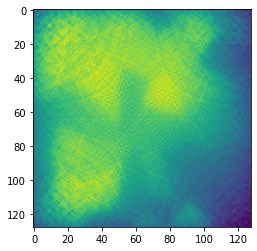

In [137]:
true = OP.T@sino.reshape((-1,1))
plt.imshow(true.reshape((sizex, sizey)))

In [138]:
sino = operatorf(x_true).reshape((-1,1))
sino.shape
xback = operatorb(sino).reshape((-1,1))
xback.shape

(16384, 1)

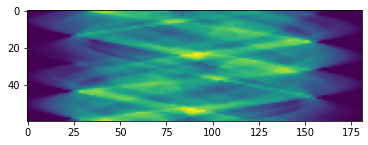

In [139]:
plt.imshow(sino.reshape((p,q)))

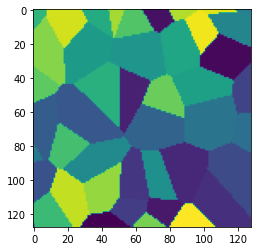

In [140]:
plt.imshow(x_true.reshape((sizex, sizey)))

In [148]:
from trips.operators import *
L = spatial_derivative_operator(sizex, sizey, 1)
data_vec = sino.reshape((-1,1))
from trips.solvers.gks_all import *
(x_gks, info) = GKS(OP, data_vec, L, projection_dim=3, n_iter = 4, regparam = 0.00001, x_true=x_true.reshape(-1,1))

running GKS...: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


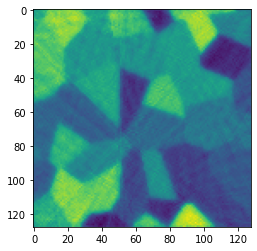

In [149]:
plt.imshow(x_gks.reshape((sizex, sizey)))

In [ ]:
proj_forward = lambda X: np.fliplr(astra.create_sino(X.reshape((self.nx,self.ny), order='F'), TT.define_proj_id(self.nx, self.ny, self.views))[1].flatten())
proj_backward = lambda B: astra.create_backprojection(np.fliplr(x_true.reshape((self.q, self.p))), self.proj_id)[1]
OperatorOut = pylops.FunctionOperator(proj_forward, proj_backward, self.nx*self.ny)

In [67]:
def geni_data(x, matrix, nx, ny, views):
        proj_id = TT.define_proj_id(nx, ny, views)
        if matrix == False:
            A = TT.forward_Op(nx, ny, views)
            b = A@x.reshape((-1,1))
            bshape = b.shape
            p = views
            q = int(bshape[0]/views)
            bimage = b.reshape((p, q))
        # elif matrix == False:
        #     A = self.forward_Op(self.nx, self.ny, self.views)
        #     b = A@x.reshape((-1,1))
        #     bshape = b.shape
        #     self.p = self.views
        #     self.q = int(bshape[0]/self.views)
        #     bimage = b.reshape((self.p, self.q))
        return (A, b, p, q)

In [27]:
(A, b_true, p, q) = geni_data(x_true, False, nx, ny, views)

In [28]:
b_true.shape

(7680,)

In [8]:
(b, delta) = TT.add_noise(b_true.reshape((-1,1)), 'Gaussian', 0.01)

In [30]:
b_vec = b.reshape((-1,1))

In [31]:
x_naive = A.T@b_vec
plt.imshow(x_naive.reshape((sizex, sizey)))

ValueError: The dimensions of the data do not match those specified in the geometry: (7680, 1) != (60, 128)

In [13]:
from trips.operators import *
L = spatial_derivative_operator(128, 128, 1)
data_vec = b_vec.reshape((-1,1))
from trips.solvers.gks_all import *
(x_gks, info) = GKS(A, data_vec, L, projection_dim=3, n_iter = 5, regparam = 'dp', x_true=x_true.reshape(-1,1), delta = np.linalg.norm(delta))

running GKS...:   0%|          | 0/5 [00:00<?, ?it/s]

here


/Users/mirjetapasha/opt/anaconda3/lib/python3.8/site-packages/trips/parameter_selection/discrepancy_principle.py:86: RuntimeWarning: divide by zero encountered in true_divide
  beta_new = beta - f/f_prime
/Users/mirjetapasha/opt/anaconda3/lib/python3.8/site-packages/trips/parameter_selection/discrepancy_principle.py:73: RuntimeWarning: invalid value encountered in multiply
  zbeta = (((singular_values*beta + 1)**(-1))*bhat.reshape((-1,1))).reshape((-1,1))
running GKS...:   0%|          | 0/5 [00:17<?, ?it/s]

0
13942373.438496927
1
7106256.648680133
2
3982712.426301392
3
2324797.9148461497
4
1282635.6259466824
5
705740.6994339261
6
355518.7742781346
7
173072.89864959728
8
90974.20843571123
9
56897.473356093404
10
46463.81824615325
11
45539.962510600635
12
45538.60527747319
13
45538.60527746836
14
45538.60527746836
15
45538.60527746836
16


ValueError: array must not contain infs or NaNs

In [13]:
plt.imshow(x_gks.reshape((sizex, sizey)))

NameError: name 'x_gks' is not defined

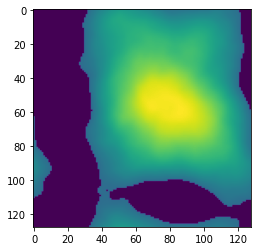

In [14]:
plt.imshow(x_true.reshape((sizex, sizey)))

In [16]:
(A, x_true, b) = Tomo.generate_saved_data(dataset = 90)

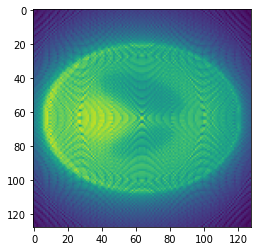

In [9]:
x_n = A.T*b.reshape((-1,1))
plt.imshow(x_n.reshape((128,128)))

In [34]:
from trips.operators import *
L = spatial_derivative_operator(128, 128, 1)
data_vec = b.reshape((-1,1))
from trips.solvers.gks_all import *
(x_gks, info) = GKS(A, data_vec, L, projection_dim=3, n_iter=3, regparam = 0.1, x_true=x_true.reshape(-1,1))

running GKS...: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


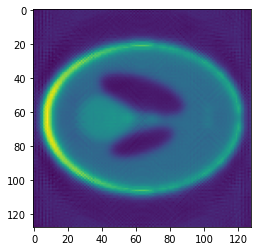

In [35]:
plt.imshow(x_gks.reshape((128,128)))

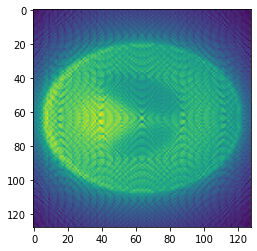

In [9]:
plt.imshow(b_true)
x_naive = A.T*b_true.reshape((-1,1))
plt.imshow(x_naive.reshape((128, 128)))

In [27]:
from trips.operators import *
L = spatial_derivative_operator(128, 128, 1)
data_vec = b_true.reshape((-1,1))
from trips.solvers.gks_all import *
(x_gks, info) = GKS(A, data_vec, L, projection_dim=3, n_iter=3, regparam = 0.1, x_true=x_true.reshape(-1,1))

ValueError: could not broadcast input array from shape (9000,) into shape (102400,)

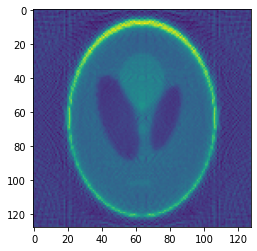

In [16]:
plt.imshow(x_gks.reshape((128,128)))

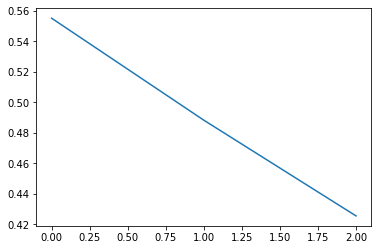

In [19]:
r_err = info['relError']
plt.plot(r_err)

In [7]:
CT = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/CT_x512_proj200_loc512.mat')
# CT_name = 'CT_x512_proj200_loc512'
dat_name = 'head'
# CT = spio.loadmat('./'+CT_name+'.mat')
A,phi,s = CT['A'],CT['phi'],CT['s']
data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/'+dat_name+'.mat')
x_true,b = data['x_true'], data['b']
b = b.T

In [8]:
from trips.solvers.golub_kahan_tikhonov import *

In [9]:
x, lambd = golub_kahan_tikhonov(A, b.reshape((-1,1)), n_iter=15, regparam='gcv')

generating basis...:   0%|          | 0/3 [00:00<?, ?it/s]

generating basis...: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


In [1]:
from trips.operators import *
L = spatial_derivative_operator(512, 512, 1)
data_vec = b.reshape((-1,1))
from trips.solvers.gks_all import *
(x_gks, info) = GKS(A, data_vec, L, projection_dim=3, n_iter=3, regparam = 0.001, x_true=x_true.reshape(-1,1))

NameError: name 'b' is not defined

(-0.5, 511.5, 511.5, -0.5)

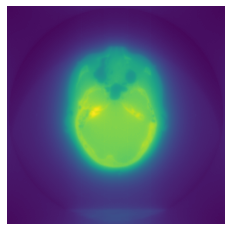

In [62]:
x = x.reshape((512, 512)).T
# x = x.T
plt.imshow(x)
plt.axis('off')

In [42]:
b = b.T
x_n = A.T*b.reshape((-1,1))

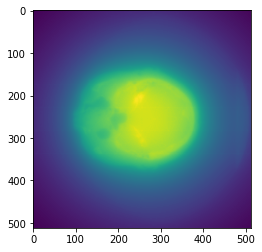

In [43]:
plt.imshow(x_n.reshape((512,512)))

In [12]:
# from trips.operators import *
# L = spatial_derivative_operator(512, 512, 1)
# data_vec = b.reshape((-1,1))
# from trips.solvers.gks_all import *
# (x_gks, info) = GKS(A, data_vec, L, projection_dim=1, n_iter=3, regparam = 'gcv', x_true=None)

In [13]:
plt.imshow(x_gks.reshape((512, 512)))

NameError: name 'x_gks' is not defined

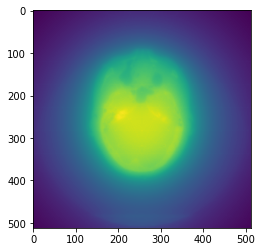

In [ ]:
x_naive = A.T*bnew.reshape((-1,1))
plt.imshow(x_naive.reshape((512,512)))

In [19]:
CT = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/CT_x128_proj60_loc100.mat')
A, phi, s = CT['A'],CT['phi'],CT['s']
data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/Shepp-Logan_proj60_SNR100.mat')
x_true = data['x_true']
b = A*x_true.reshape((-1,1))

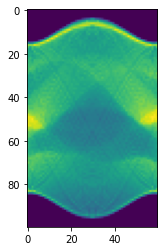

In [22]:
plt.imshow(b.reshape((100,60)))

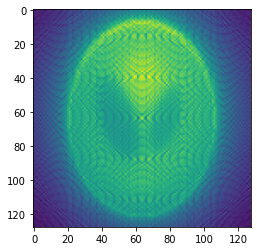

In [24]:
x_n = A.T*b
plt.imshow((x_n.reshape((128,128))))

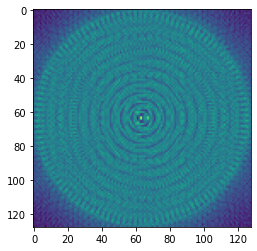

running GKS...:   0%|          | 0/3 [00:00<?, ?it/s]

running GKS...: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


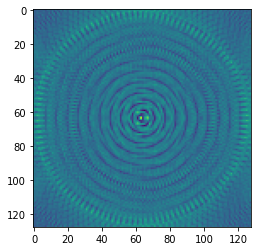

In [15]:
plt.imshow(x_gks[0].reshape((128,128)))

(-0.5, 127.5, 127.5, -0.5)

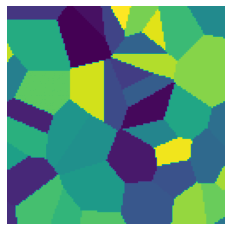

In [16]:
xtrue = Tomo.generate_true(test_problem = 'grains', sizex = sizex, sizey = sizey)
plt.imshow(xtrue.reshape((sizex, sizey)))
plt.axis('off')

In [17]:
b = Tomo.generate_data(x = xtrue, matrix = False)
plt.imshow(b.reshape((60, 100)))
Tomo.plot_data(b)

AttributeError: 'Tomography' object has no attribute 'sizex'

In [27]:
(b_noise, delta) = Tomo.add_noise(b, opt = 'Gaussian', noise_level = 0.01)

In [28]:
np.linalg.norm(delta)

27.46125712558026

In [29]:
from trips.solvers.gks_all import *
(x, info) = GKS(A, b_noise, D, projection_dim = 2, n_iter = 40, regparam='gcv', x_true=x_true)

NameError: name 'A' is not defined

In [25]:
class Tomograph:
    def __init__(self,**kwargs):
        seed = kwargs.pop('seed',2022)
    def set_up(self, sizex, sizey, views, **kwargs):
        self.dataset = kwargs['dataset'] if ('dataset' in kwargs) else False
        self.nx = sizex
        self.ny = sizey
        self.views = views
        self.angles = numpy.linspace(0, numpy.pi, views, endpoint = False)
        self.slice_geom = astra.create_vol_geom(pixels, pixels)
        self.slice_id = astra.data2d.create('-vol', slice_geom, phantom)
        self.sino_geom = astra.create_proj_geom('parallel', 1, pixels, angles)
        self.sino_id = astra.data2d.create('-sino', sino_geom)
        self.proj_id = astra.creators.create_projector('linear', sino_geom, slice_geom)
        return self.proj_id

    def forward_Op_mat(self, sizex, sizey, views):
        proj_geom, proj_id = self.set_up(sizex, sizey, views)
        self.mat_id = astra.projector.matrix(proj_id)
        return astra.matrix.get(self.mat_id) 

    def forward_Op(self, sizex, sizey): 
        proj_geom, proj_id = self.set_up(sizex, sizey)       
        return astra.OpTomo(self.proj_id)

    def generate_true(self, test_problem):
        if test_problem == 'grains':
            N_fine = self.nx
            numGrains = int(round(4*np.sqrt(N_fine)))
            x_true = phantom.grains(N_fine, numGrains) 
            x_truef = x_true.flatten(order='F') 
        elif test_problem == 'smooth':
            N_fine = self.nx
            x_true = phantom.smooth(N_fine) 
            x_truef = x_true.flatten(order='F') 
        elif test_problem == 'tectonic':
            N_fine = self.nx
            x_true = phantom.tectonic(N_fine) 
            x_truef = x_true.flatten(order='F') 
        elif test_problem == 'threephases':
            N_fine = self.nx
            x_true = phantom.threephases(N_fine) 
            x_truef = x_true.flatten(order='F') 
        elif test_problem == 'ppower':
            N_fine = self.nx
            x_true = phantom.ppower(N_fine) 
            x_truef = x_true.flatten(order='F') 
        elif test_problem == 'CT60':
            self.nx = 128
            self.ny = 128
            data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/Shepp-Logan_proj60_SNR100.mat')
            x_true = data['x_true']
            x_truef = x_true.flatten(order='F') 
        elif test_problem == 'CT90':
            self.nx = 128
            self.ny = 128
            data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/Shepp-Logan_proj90_SNR100.mat')
            x_true = data['x_true']
            x_truef = x_true.flatten(order='F') 
        return x_truef
    def generate_data(self, x, proj_type, flag, dataset):
        if flag == 'given_operator':
            if dataset == 60:
                CT = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/CT_x128_proj60_loc100.mat')
                A, phi, s = CT['A'],CT['phi'],CT['s']
                data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/Shepp-Logan_proj60_SNR100.mat')
                b_true = data['b']
                out = b_true.flatten()
                self.q = phi.shape[1]
                self.p = s.shape[1]
            elif dataset == 90:
                CT = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/CT_x128_proj90_loc100.mat')
                A, phi, s = CT['A'],CT['phi'],CT['s']
                data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/Shepp-Logan_proj60_SNR100.mat')
                b_true = data['b']
                out = b_true.flatten()
                self.q = phi.shape[1]
                self.p = s.shape[1]
        elif flag =='no_given_operator':
            if proj_type == 1:
                # forward projection
                _, b = astra.create_sino(x.reshape((self.nx,self.nx), order='F'), self.proj_id)
                b = np.fliplr(b)
                out = b.flatten()
            elif proj_type == 2:
                # backward projection   
                b = np.fliplr(x.reshape((self.q, self.p)))
                _, ATb = astra.create_backprojection(b, self.proj_id)
                b = ATb.flatten(order='F')
        else: ##MP: Will develop the true data case here
            if proj_type == 1:
                # performs the forward projection
                _, Ax = astra.create_sino(x.reshape((self.nx,self.nx), order='F'), self.proj_id)
                Ax = np.fliplr(Ax)
                out = Ax.flatten()
            elif proj_type == 2:
                # performs the backward projection   
                b = np.fliplr(x.reshape((self.q, self.p)))
                _, ATb = astra.create_backprojection(b, self.proj_id)
                b = ATb.flatten(order='F')
        return out
    def add_noise(self, b_true, opt, noise_level):
        if (opt == 'Gaussian'):
            # mu_obs = np.zeros((self.p*self.q,1))      # mean of noise
            noise = np.random.randn(b_true.shape[0]).reshape(-1,1)
            e = noise_level * np.linalg.norm(b_true) / np.linalg.norm(noise) * noise
            e = e.reshape(-1,1)
            b_true = b_true.reshape(-1,1)
            b = b_true + e # add noise
            b_meas = b_true + e
            b_meas_i = b_meas.reshape((self.p, self.q), order='F')
        elif (opt == 'Poisson'):
            # Add Poisson Noise 
            gamma = 1 # background counts assumed known
            b_meas = np.random.poisson(lam=b_true+gamma) 
            b_meas_i = b_meas.reshape((self.p, self.q), order='F')
        else:
            mu_obs = np.zeros(self.p*self.q)      # mean of noise
            e = np.random.laplace(self.p*self.q)
            sig_obs = noise_level * np.linalg.norm(b_true)/np.linalg.norm(e)
            b_meas = b_true + sig_obs*e
            b_meas_i = b_meas.reshape((self.p, self.q), order='F')
        return (b_meas_i , e)

    def plot_rec(self, img, save_imgs=True, save_path='./saveImagesTomo'):
            plt.set_cmap('inferno')
            if save_imgs and not os.path.exists(save_path): os.makedirs(save_path)
            plt.imshow(img.reshape((self.nx, self.ny), order = 'F'))
            plt.axis('off')
            if save_imgs:  plt.savefig(save_path+'/rec'+'.png',bbox_inches='tight')
            plt.pause(.1)
            plt.draw()
        
    def plot_data(self, img, save_imgs = False, save_path='./saveImagesData'):
        plt.set_cmap('inferno')
        if save_imgs and not os.path.exists(save_path): os.makedirs(save_path)
        plt.imshow(img.reshape((self.p, self.q), order = 'F'))
        plt.axis('off')
        if save_imgs:  plt.savefig(save_path+'/sino'+'.png',bbox_inches='tight')
        plt.pause(.1)
        plt.draw()

In [26]:
sizex = 250
sizey = 250
views = 60
TT = Tomograph(sizex = sizex, sizey = sizey, views = views)

In [27]:
TT.generate_true(test_problem = 'grains')

AttributeError: 'Tomograph' object has no attribute 'nx'